In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib
import string
import os.path
import statsmodels.api as sm
from copy import deepcopy
import attr

import rpy2.robjects as ro
Rload = ro.r('readRDS')
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from uncertaintyFunctions import *
from constants import *

%matplotlib inline

/Users/naomi/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
font = {'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

## First, global mean annual mean temperature 

## To make a plot with all default options, here is the minimum that you need to specify.

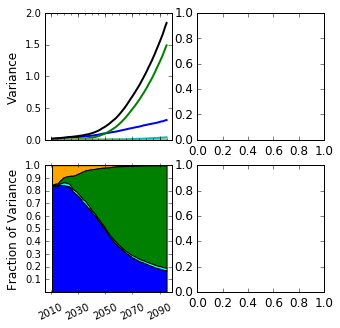

In [3]:
field = 'tas'
region = 'global'

options = defaults()

nColumns = 2
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))

column = 0
plotColumn(ax,column,field,region,options)


### Note that nColumns must be >=2 or the axes object will not have the correct dimensions that some of the functions expect.

## Now plot this for several methods and sets of input data, using confidence intervals and an extra row of plots of the input time-series, spaghetti plot style for all four scenarios.

/Users/naomi/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


internal variance CMIP5  , N= 278 :  0.00347608459167  range:  0.00270615512024 0.00428561711173
internal variance CMIP5 -all+LE , N= 318 :  0.00384399006995  range:  0.00315136519553 0.00460863176694
internal variance CMIP5 -1run+LE , N= 159 :  0.0051597072419  range:  0.0030452444686 0.00730454779962
internal variance H&S smoothed method, N= 68 :  0.0048542968525
internal variance H&S default method, N= 68 :  0.00442696276249


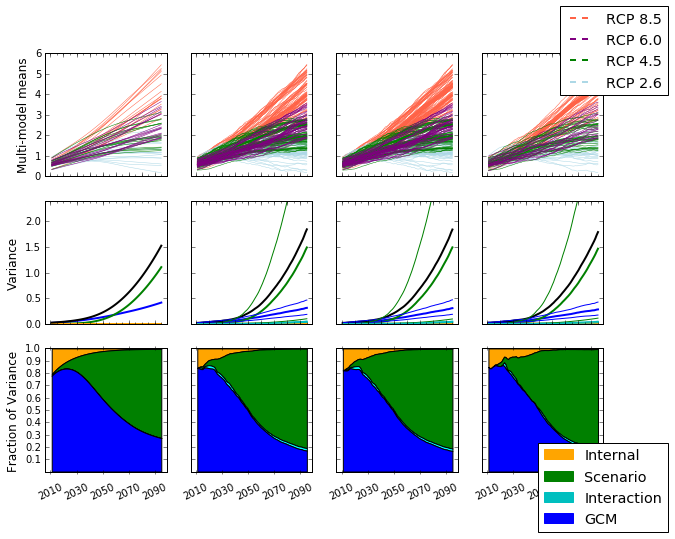

In [4]:
field = 'tas'
region = 'global'

options = defaults(nRows=3,season='annual',confidenceIntervals=True,ylimVariance=[0,2.4], \
                  ylimMeanRow=[0,6],spaghetti=True,scenarios=['rcp85','rcp26','rcp45','rcp60'])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,
                       figsize=(2.5*nColumns,2.5*options.nRows))

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
#also print the value gotten with the H&S 4th order polynomial:
options.internal='default'
anomaly = getAnomaly(field,region,options)
internalComponent, modelComponent, scenarioComponent, smoothed = getVariancesHandS(region,anomaly,options)

plotLegend(fig)

### The only options for nRows are 2 or 3. Three will give you the extra row at the top.
### Note that if you plot multiple columns, axis ticks are only labeled on the left-most, but all the columns might have (unlabeled) different y-scales. For this reason you should specify ylimVariance, and ylimMeanRow (if there's an extra first row), so that all columns have the same y-limits for a given row.

## For fun, let's print the variance between runs by model for one scenario.

In [5]:
smoothed = getSmoothed('tas','global',defaults()) 

for model in smoothed['rcp85'].transpose().index.get_level_values('model').unique():
    numRuns = smoothed['rcp85'][model].transpose().count().mode()[0]
    if numRuns > 1:
        print model, ' \t', numRuns, '\t', smoothed['2000':'2100']['rcp85'][model].transpose().var().mean()
    

CCSM4  	6 	0.00254055184192
CESM1-CAM5  	2 	0.00210048233624
CESM1-WACCM  	3 	0.00149969090076
CNRM-CM5  	4 	0.00228845490119
CSIRO-Mk3-6-0  	10 	0.00545389527452
CanESM2  	5 	0.00232587686004
EC-EARTH  	5 	0.00215062057586
FGOALS-s2  	2 	0.00178828113168
FIO-ESM  	3 	0.00231339121054
GISS-E2-H  	2 	0.001688854785
GISS-E2-R  	2 	0.000921017133875
HadGEM2-CC  	2 	0.0114462008173
HadGEM2-ES  	3 	0.00483249834532
IPSL-CM5A-LR  	4 	0.00385265003737
MIROC5  	3 	0.00617651904619
MPI-ESM-LR  	2 	0.00283980153892


## And the number of runs by model for each scenario

In [6]:
smoothed = getSmoothed('tas','global',defaults()) 

byModel = smoothed['20000101'::].transpose().groupby(level='model')
#construct a model list
modelList = list(smoothed.columns.levels[1]) 
print "num models: ", len(modelList)
print modelList
for model in modelList:
    print model, ": \t \t", len(list(smoothed['rcp85'][model].columns)), '\t', \
            len(list(smoothed['rcp60'][model].columns)), '\t', \
            len(list(smoothed['rcp45'][model].columns)), '\t', \
            len(list(smoothed['rcp26'][model].columns))

num models:  42
['ACCESS1-0', 'ACCESS1-3', 'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CESM1-WACCM', 'CMCC-CESM', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'EC-EARTH', 'FGOALS-g2', 'FGOALS-s2', 'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-M', 'NorESM1-ME', 'bcc-csm1-1', 'bcc-csm1-1-m', 'inmcm4']
ACCESS1-0 : 	 	1 	0 	1 	0
ACCESS1-3 : 	 	1 	0 	1 	0
BNU-ESM : 	 	1 	0 	1 	1
CCSM4 : 	 	6 	6 	6 	6
CESM1-BGC : 	 	1 	0 	1 	0
CESM1-CAM5 : 	 	2 	3 	3 	3
CESM1-WACCM : 	 	3 	0 	3 	1
CMCC-CESM : 	 	1 	0 	0 	0
CMCC-CM : 	 	1 	0 	1 	0
CMCC-CMS : 	 	1 	0 	1 	0
CNRM-CM5 : 	 	4 	0 	1 	1
CSIRO-Mk3-6-0 : 	 	10 	10 	9 	10
CanESM2 : 	 	5 	0 	5 	5
EC-EARTH : 	 	5 	0 	8 	2
FGOALS-g2 : 	 	1 	0 	1 	1
FGOALS-s2 : 	 	2 	0 	0 	0
FIO-ESM 

In [7]:
##list scenarios that exist for a given model
#smoothed.swaplevel(0,1,axis=1).swaplevel(1,2,axis=1)['ACCESS1-0']['run1'].columns.values

##list models that exist for a given scenario
#smoothed.swaplevel(1,2,axis=1)['rcp26']['run1'].columns.values

##list all runs that exist for a model/scenario pair:
#len(smoothed['rcp26']['GISS-E2-H'].columns.values)

## Global mean annual mean Precipitation

internal variance CMIP5  , N= 280 :  1.93847559836e-05  range:  1.51499018795e-05 2.37094200277e-05
internal variance CMIP5 -all+LE , N= 320 :  2.38390844921e-05  range:  1.94942866081e-05 2.85162605338e-05
internal variance CMIP5 -1run+LE , N= 160 :  3.90754732555e-05  range:  2.46027504613e-05 5.5095386741e-05
internal variance H&S smoothed method, N= 72 :  2.65928635091e-05
internal variance H&S default method, N= 72 :  2.4105853094e-05


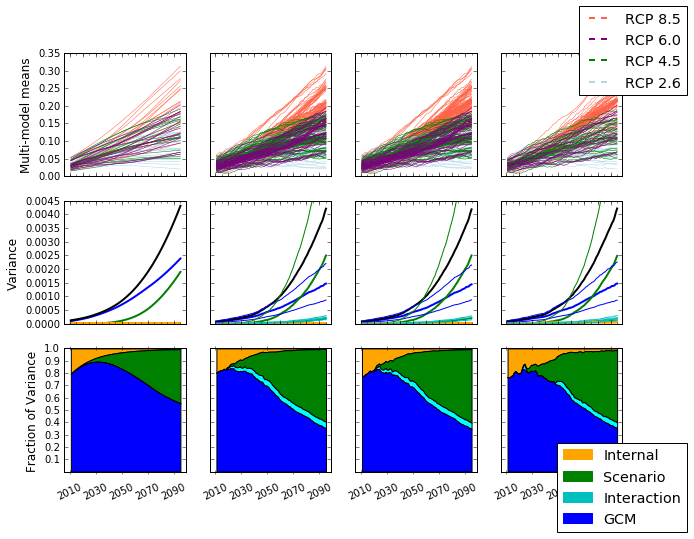

In [8]:
field = 'pr'
region = 'global'

options=defaults(nRows=3,confidenceIntervals=True,ylimVariance=[0,0.0045],ylimMeanRow=[0,0.35],
                spaghetti=True,scenarios=['rcp85','rcp26','rcp45','rcp60'])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
#also print the value gotten with the H&S 4th order polynomial:
options.internal='default'
anomaly = getAnomaly(field,region,options)
internalComponent, modelComponent, scenarioComponent, smoothed = getVariancesHandS(region,anomaly,options)

plotLegend(fig)

## Annual mean, NW temperature:

internal variance CMIP5  , N= 278 :  0.0501375301255  range:  0.0393825153668 0.0606772846848
internal variance CMIP5 -all+LE , N= 318 :  0.0504072490472  range:  0.0413931028793 0.0599131291553
internal variance CMIP5 -1run+LE , N= 159 :  0.0488916109008  range:  0.0288789094547 0.0683074043535
internal variance H&S smoothed method, N= 68 :  0.0635145795969
internal variance H&S default method, N= 68 :  0.0638564363673


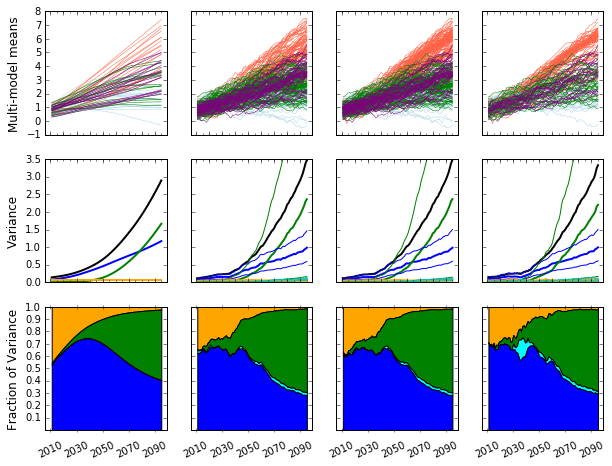

In [9]:
field = 'tas'
region = 'pnw'

options = defaults(nRows=3,season='annual',confidenceIntervals=True,ylimVariance=[0,3.5], \
                  ylimMeanRow=[-1,8],spaghetti=True,scenarios=['rcp85','rcp26','rcp45','rcp60'])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
#also print the value gotten with the H&S 4th order polynomial:
options.internal='default'
anomaly = getAnomaly(field,region,options)
internalComponent, modelComponent, scenarioComponent, smoothed = getVariancesHandS(region,anomaly,options)


internal variance CMIP5  , N= 278 :  0.0501375301255  range:  0.0393825153668 0.0606772846848
internal variance CMIP5 -all+LE , N= 318 :  0.0504072490472  range:  0.0413931028793 0.0599131291553
internal variance CMIP5 -1run+LE , N= 159 :  0.0488916109008  range:  0.0288789094547 0.0683074043535
internal variance H&S smoothed method, N= 68 :  0.0635145795969


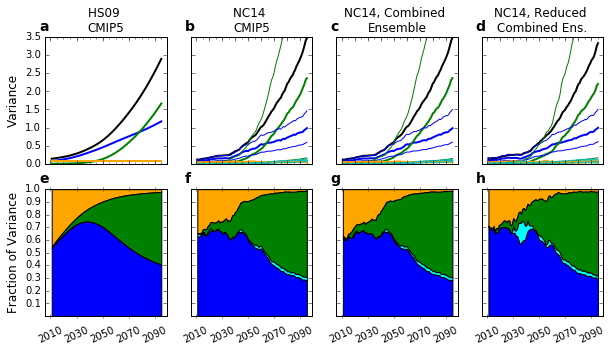

In [10]:
field = 'tas'
region = 'pnw'

options = defaults(nRows=2,season='annual',confidenceIntervals=True,ylimVariance=[0,3.5])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 1
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14 \nCMIP5',size=12)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14, Combined \nEnsemble',size=12)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14, Reduced \nCombined Ens.',size=12)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('HS09 \nCMIP5',size=12)

#plt.savefig('figureS1final.eps')


# NW temperature with after-the-fact smoothing

In [11]:
len(smoothed.columns)

68

internal variance H&S smoothed method, N= 68 :  0.0635145795969


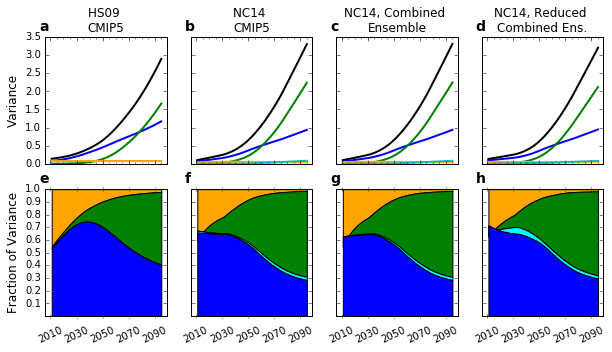

In [12]:
field = 'tas'
region = 'pnw'

options = defaults(nRows=2,season='annual',smooth=0.5,ylimVariance=[0,3.5])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 1
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14 \nCMIP5',size=12)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14, Combined \nEnsemble',size=12)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14, Reduced \nCombined Ens.',size=12)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('HS09 \nCMIP5',size=12)

#plt.savefig('figure1revised.eps')


## Now, annual mean NW precipitation

internal variance CMIP5  , N= 280 :  0.0110535888292  range:  0.00877833559444 0.0131934794162
internal variance CMIP5 -all+LE , N= 320 :  0.0107472115996  range:  0.0088624221403 0.0125959945053
internal variance CMIP5 -1run+LE , N= 160 :  0.0092483212045  range:  0.00574325874086 0.0127872800495
internal variance H&S smoothed method, N= 72 :  0.0123553415293


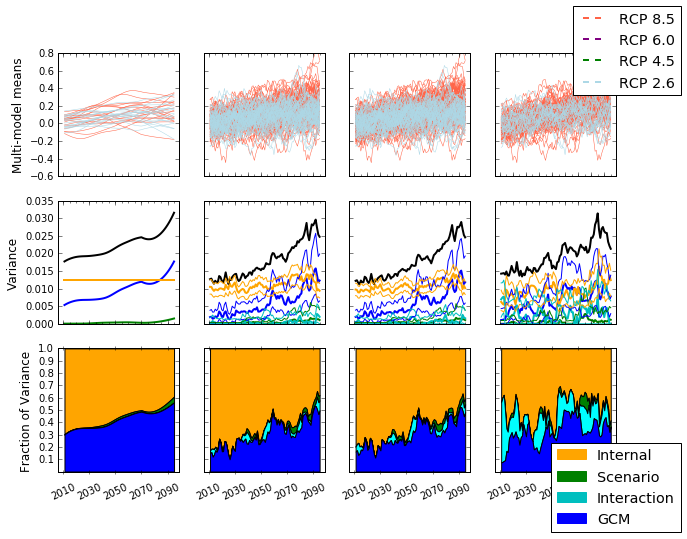

In [13]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=3,confidenceIntervals=True,ylimVariance=[0,0.035], \
                   ylimMeanRow=[-0.6,0.8],spaghetti=True)

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)

plotLegend(fig)

### Version for paper supplement:

internal variance CMIP5  , N= 280 :  0.0110535888292  range:  0.00877833559444 0.0131934794162
internal variance CMIP5 -all+LE , N= 320 :  0.0107472115996  range:  0.0088624221403 0.0125959945053
internal variance CMIP5 -1run+LE , N= 160 :  0.0092483212045  range:  0.00574325874086 0.0127872800495
internal variance H&S smoothed method, N= 72 :  0.0123553415293


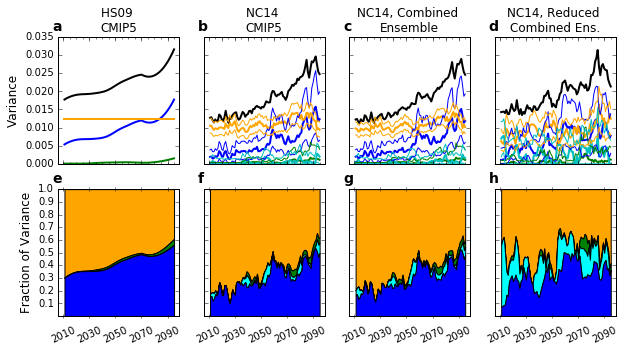

In [14]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=2,confidenceIntervals=True,ylimVariance=[0,0.035])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 1
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14 \nCMIP5',size=12)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14, Combined \nEnsemble',size=12)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14, Reduced \nCombined Ens.',size=12)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('HS09 \nCMIP5',size=12)

#plt.savefig('figureS2revised.eps')


### Version for paper:

internal variance H&S smoothed method, N= 72 :  0.0123553415293


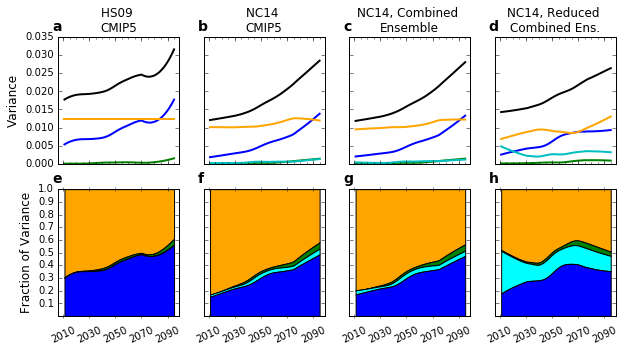

In [15]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=2,smooth=0.5,ylimVariance=[0,0.035])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 1
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14 \nCMIP5',size=12)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14, Combined \nEnsemble',size=12)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14, Reduced \nCombined Ens.',size=12)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('HS09 \nCMIP5',size=12)


#plt.savefig('figure2revised.eps')


## Figure out what after-the-fact smoothing to use on the N&C decadal results

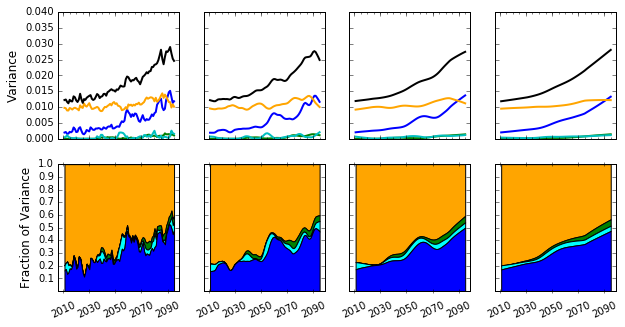

In [16]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=2,ylimVariance=[0,0.04],ensemble='-all+LE')

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))

column = 0
plotColumn(ax,column,field,region,options)

column = 1
options.smooth=0.1
plotColumn(ax,column,field,region,options)

column = 2
options.smooth=0.3
plotColumn(ax,column,field,region,options)

column = 3
options.smooth=0.5
plotColumn(ax,column,field,region,options)

## Hawkins and Sutton results with a) 4th order polynomial, b) Lowess filter

internal variance H&S default method, N= 72 :  0.0127473993674
internal variance H&S smoothed method, N= 72 :  0.0123553415293


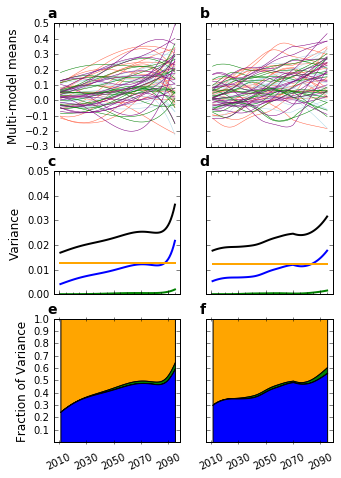

In [17]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=3,ylimVariance=[0,0.05],ylimMeanRow=[-0.3,0.5],spaghetti=True, \
                  scenarios=['rcp85','rcp26','rcp45','rcp60'],HandS=True,internal='default')

nColumns = 2
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,region,options)
column = 1
options.internal='smoothed'
plotColumn(ax,column,field,region,options)


### For paper supplement:

internal variance H&S default method, N= 72 :  0.0127473993674
internal variance H&S smoothed method, N= 72 :  0.0123553415293


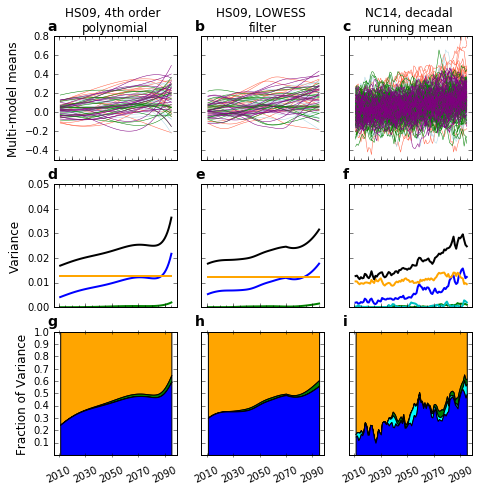

In [18]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=3,ylimVariance=[0,0.05],ylimMeanRow=[-0.5,0.8],spaghetti=True, \
                  scenarios=['rcp85','rcp26','rcp45','rcp60'],internal='default')

nColumns = 3
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 2
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('NC14, decadal \nrunning mean',size=12)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('HS09, 4th order \npolynomial',size=12)

column = 1
options.internal='smoothed'
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('HS09, LOWESS \nfilter',size=12)

#plt.savefig('figureS0a.pdf')

## Seasons NW Precipitation: DJF, JJA
## CMIP5, all runs + CESM LE (combined ensemble)

internal variance CMIP5 -all+LE , N= 321 :  0.0852694880621  range:  0.0698695842216 0.100142346794
internal variance CMIP5 -all+LE , N= 320 :  0.0176716584418  range:  0.0145525203674 0.0208373839077


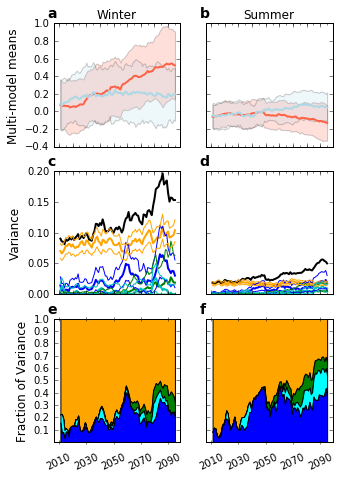

In [19]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=3,confidenceIntervals=True,ylimVariance=[0,0.2], \
                   ylimMeanRow=[-0.4,1.0],ensemble='-all+LE')

nColumns = 2
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
options.season='DJF'
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('Winter',size=12)
column = 1
options.season='JJA'
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('Summer',size=12)

#plt.savefig('figureS3revised.pdf')

### The multimodel means with standard deviation shading for each scenario are the default for the top row (spaghetti=False)

### Version for paper:

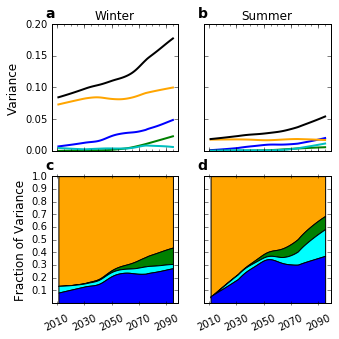

In [20]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=2,smooth=0.5,ylimVariance=[0,0.2],ensemble='-all+LE')

nColumns = 2
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
options.season='DJF'
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('Winter',size=12)
column = 1
options.season='JJA'
plotColumn(ax,column,field,region,options)
plt.axes(ax[0,column])
plt.title('Summer',size=12)


#plt.savefig('figure3revised.eps')

## Now, annual mean precipitation for all the regions:

### Version for supplement:

internal variance CMIP5 -all+LE , N= 320 :  0.00446973940926  range:  0.0036846489056 0.00526194894144
internal variance CMIP5 -all+LE , N= 320 :  0.010409421947  range:  0.0085661052843 0.0123100813544
internal variance CMIP5 -all+LE , N= 320 :  0.0107472115996  range:  0.0088624221403 0.0125959945053
internal variance CMIP5 -all+LE , N= 320 :  0.0160646765363  range:  0.0132072901277 0.0189755246406
internal variance CMIP5 -all+LE , N= 320 :  0.0068747799212  range:  0.00565865460658 0.00813394411912


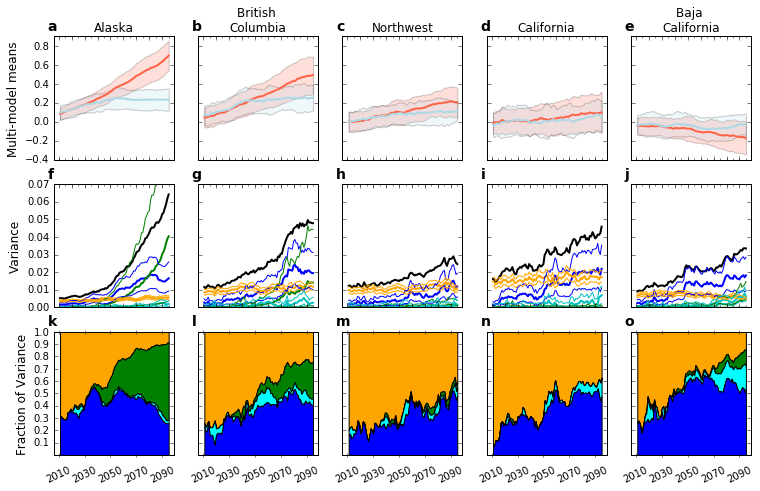

In [21]:
field = 'pr'

options = defaults(nRows=3,confidenceIntervals=True,ylimVariance=[0,0.07], \
                   ylimMeanRow=[-0.4,0.9],ensemble='-all+LE')

nColumns = 5
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,'Alaska',options)
plt.axes(ax[0,column])
plt.title('Alaska',size=12)

column = 1
plotColumn(ax,column,field,'BC',options)
plt.axes(ax[0,column])
plt.title('British \nColumbia',size=12)

column = 2
plotColumn(ax,column,field,'pnw',options)
plt.axes(ax[0,column])
plt.title('Northwest',size=12)

column = 3
plotColumn(ax,column,field,'Cali',options)
plt.axes(ax[0,column])
plt.title('California',size=12)

column = 4
plotColumn(ax,column,field,'Baja',options)
plt.axes(ax[0,column])
plt.title('Baja \nCalifornia',size=12)

#plt.savefig('figureS4revised.pdf')

## afterwards smoothing, precip all regions

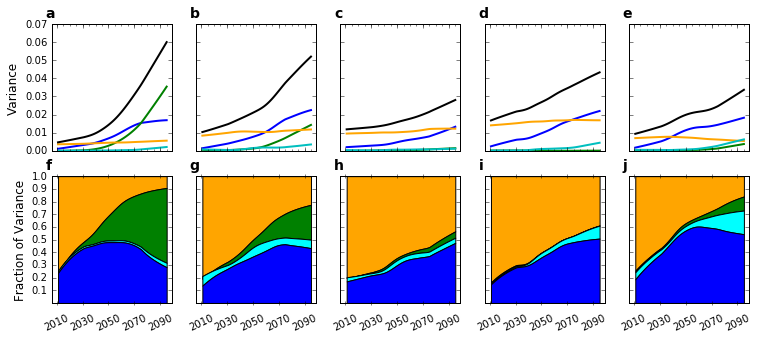

In [22]:
field = 'pr'

options = defaults(nRows=2,smooth=0.5,ylimVariance=[0,0.07],ensemble='-all+LE')

nColumns = 5
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,'Alaska',options)
column = 1
plotColumn(ax,column,field,'BC',options)
column = 2
plotColumn(ax,column,field,'pnw',options)
column = 3
plotColumn(ax,column,field,'Cali',options)
column = 4
plotColumn(ax,column,field,'Baja',options)

#plt.savefig('figure4revised.eps')

### With time series based only on >50% landcover grid cells:

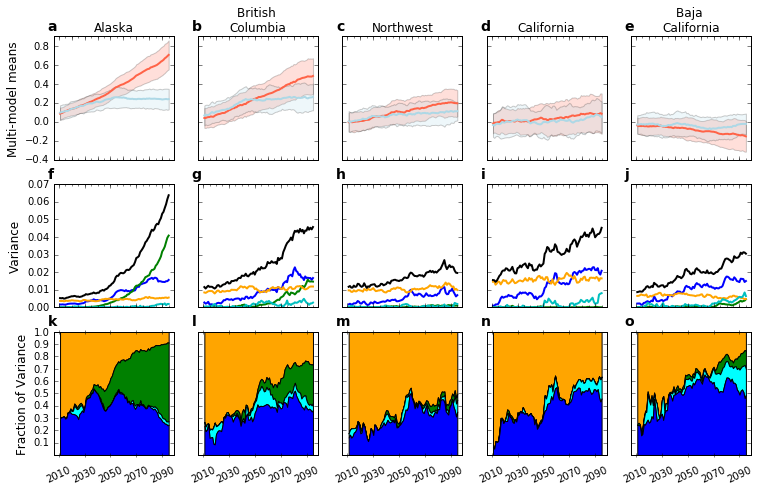

In [23]:
field = 'pr'

options = defaults(nRows=3,confidenceIntervals=False,ylimVariance=[0,0.07], \
                   ylimMeanRow=[-0.4,0.9],ensemble='-all+LE',landOnly='LO')

nColumns = 5
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,'Alaska',options)
plt.axes(ax[0,column])
plt.title('Alaska',size=12)

column = 1
plotColumn(ax,column,field,'BC',options)
plt.axes(ax[0,column])
plt.title('British \nColumbia',size=12)

column = 2
plotColumn(ax,column,field,'pnw',options)
plt.axes(ax[0,column])
plt.title('Northwest',size=12)

column = 3
plotColumn(ax,column,field,'Cali',options)
plt.axes(ax[0,column])
plt.title('California',size=12)

column = 4
plotColumn(ax,column,field,'Baja',options)
plt.axes(ax[0,column])
plt.title('Baja \nCalifornia',size=12)

## the version generated with the informative prior for scenario using BUGS:

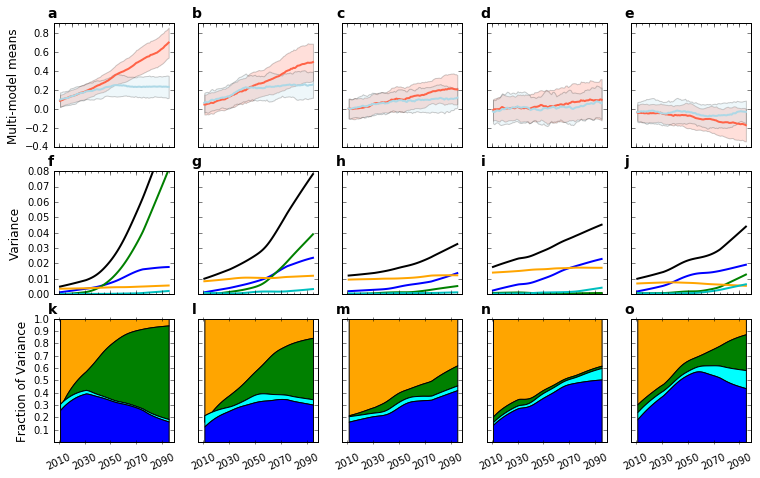

In [24]:
field = 'pr'

options = defaults(nRows=3,smooth=0.5,ylimVariance=[0,0.08],ylimMeanRow=[-0.4,0.9], \
                   ensemble='-all+LE',append='-Bayes')

nColumns = 5
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,'Alaska',options)
column = 1
plotColumn(ax,column,field,'BC',options)
column = 2
plotColumn(ax,column,field,'pnw',options)
column = 3
plotColumn(ax,column,field,'Cali',options)
column = 4
plotColumn(ax,column,field,'Baja',options)


## Temperature all regions

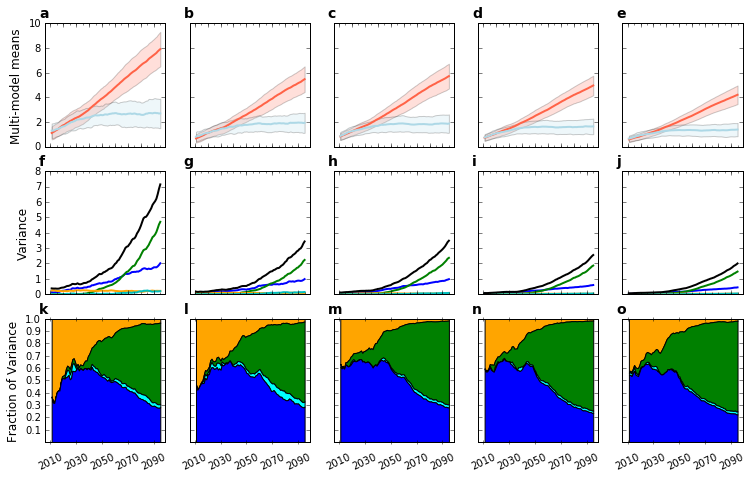

In [25]:
field = 'tas'

options = defaults(nRows=3,ylimVariance=[0,8], \
                   ylimMeanRow=[0,10],ensemble='-all+LE')

nColumns = 5
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,'Alaska',options)
column = 1
plotColumn(ax,column,field,'BC',options)
column = 2
plotColumn(ax,column,field,'pnw',options)
column = 3
plotColumn(ax,column,field,'Cali',options)
column = 4
plotColumn(ax,column,field,'Baja',options)

